In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

# Advection-Diffusion linéaires:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [9]:
#La Solution Iniciale:
@njit
def u0(x):
    if  x>=1.5 and x<=2.5:
        return 1
    else: return 0



# Le flux Exacte:
@njit
def F(u,a):
    return a*u

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a))-a*(ud-ug)
@njit

def Rusanov2(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-a*(ud-ug))
@njit
def Roe(ug,ud,a,dx,dt):
    if a >= 0:
        return F(ug,a)
    else:
        return F(ud,a)
    
@njit   
def LF(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dx/(dt))*(ud-ug))
       
@njit
def LFM(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-0.5*(dx/(dt))*(ud-ug))
       
    
@njit
def LW(ug,ud, a, dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dt/dx)*(a**2)*(ud-ug))
       
@njit
def VFD(ug,ud, a, dx,dt):
    if a>0:
        return F(ug,a)
    else:
        return F(ud,a)

@njit
def VFC(ug,ud, a, dx,dt):
    return F(0.5*(ug+ud)-alpha*(dt/dx)*a*(ud-ug),a)
       

In [10]:
def LinearAdvectionSolver(Flux, u0, T, l, L, a, epsilon , N, CFL1, CFL2):
    
    dx = (L-l)/(N-1)
    
    X = np.linspace(l,L,N)
    
        
  
    dt1=CFL1*dx/abs(a)
    dt2=CFL2*dx**2/abs(epsilon)
    dt=min(dt1,dt2)
    
    U0=np.array([u0(x) for x in X])
    #U0=np.zeros(N)
    #for j in range(0,N):
        #U0[j]= np.sin(np.pi*X[j]/L)+0.25*np.sin(10*np.pi*X[j]/L)

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        dt=min(dt,T-dt)
        temps += dt
        for i in range(1,N-1):
            Fd=Flux(Un[i],Un[i+1], a, dx, dt)
            Fg=Flux(Un[i-1],Un[i], a, dx, dt)
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg)+ epsilon * (dt/(dx**2)) * (Un[i+1] - 2 * Un[i] + Un[i-1])

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un = Unp1.copy()
        

    return Un
    

In [11]:
T=1
l=0
L=10
a=2
epsilon=0.01
N=101
CFL1=0.5
CFL2=0.25
alpha = 0.7

Un_Roe = LinearAdvectionSolver(Roe, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_Rsnv = LinearAdvectionSolver(Rusanov, u0, T, l, L, a,epsilon, N, CFL1,CFL2)
Un_Rsnv2 = LinearAdvectionSolver(Rusanov2, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_LF = LinearAdvectionSolver(LF, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_LFM = LinearAdvectionSolver(LFM, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_LW = LinearAdvectionSolver(LW, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_VFD = LinearAdvectionSolver(VFD, u0, T, l, L, a, epsilon, N, CFL1,CFL2)
Un_VFC = LinearAdvectionSolver(VFC, u0, T, l, L, a, epsilon, N, CFL1,CFL2)


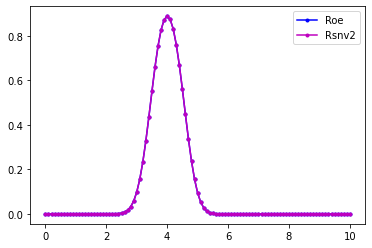

In [13]:
X = np.linspace(l,L,N)
plt.plot(X, Un_Roe, '.-b', label='Roe')
#plt.plot(X, Un_Rsnv, '*-g', label='Rsnv')
plt.plot(X, Un_Rsnv2, '.-m', label='Rsnv2')
#plt.plot(X, Un_LF, '*-y', label='L-F')
#plt.plot(X, Un_LFM, '*-c', label='L-F mod')
#plt.plot(X, Un_VFD, '*-k', label='VFD')
#plt.plot(X, Un_LW, '*-r', label='L-W')
#plt.plot(X, Un_VFC, '-k', label='VFD')

######################
#plt.xlim([6, 8])  
#plt.ylim([0.4, 0.5])  

plt.legend()
plt.pause(0.1)

In [6]:
Norm_Roe =  np.linalg.norm(Un_Roe,ord = 2) 
Norm_Rsnv =  np.linalg.norm(Un_Rsnv,ord = 2) 
Norm_Rsnv2 =  np.linalg.norm(Un_Rsnv2,ord = 2) 
Norm_LF =  np.linalg.norm(Un_LF,ord = 2) 
Norm_LFM =  np.linalg.norm(Un_LFM,ord = 2) 
Norm_VFD =  np.linalg.norm(Un_VFD,ord = 2) 
Norm_VFC =  np.linalg.norm(Un_VFC,ord = 2) 
Norm_LW =  np.linalg.norm(Un_LW,ord = 2) 

print(f"La norme pour le schema de Roe: {Norm_Roe}")
print(f"La norme pour le schema volume fini decentré: {Norm_VFD}")
print(f"La norme pour le schema Rusanov2: {Norm_Rsnv2}")
print(f"La norme pour le schema Lax-Freiderichs modifie: {Norm_LFM}")
print(f"La norme pour le schema Rusanov: {Norm_Rsnv}")
print(f"La norme pour le schema Lax-Freiderichs: {Norm_LF}")
print(f"La norme pour le schema Lax-Wendroff: {Norm_LW}")
print(f"La norme pour le schema volume fini carac: {Norm_VFC}")


La norme pour le schema de Roe: 2.679614017228057
La norme pour le schema volume fini decentré: 2.679614017228057
La norme pour le schema Rusanov2: 2.679614017228057
La norme pour le schema Lax-Freiderichs modifie: 2.4738658728431244
La norme pour le schema Rusanov: 2.4738658728431244
La norme pour le schema Lax-Freiderichs: 3.1417945766736033e+43
La norme pour le schema Lax-Wendroff: 2.917333437119123
La norme pour le schema volume fini carac: 2.8793246278279465


# Equation de Burgers avec Diffusion:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [2]:


#La Solution Iniciale:
@njit
def u0(x):
    if  x <=l+ (L-l)/4:
        return ul
    if  x >l+ (L-l)/4 and x <l+ 3*(L-l)/4:
        return um
    else:
        return ur


# Le flux Exacte:
@njit
def F(u):
    return (u**2)/2

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud))-lamda*(ud-ug)

@njit
def Rusanov2(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud)-lamda*(ud-ug))

@njit
def Roe(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (ug+ud)/2 *(ud-ug) )
            
@njit
def LF(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (dx/dt) *(ud-ug) )

@njit
def LFM(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - 0.5*(dx/dt) *(ud-ug) )

@njit
def LW(ug,ud,dx,dt):
    A=0.5*(ug+ud)
    return 0.5*(F(ug)+F(ud)-(dt/dx)*A*(F(ud)-F(ug)))

@njit
def VFC(ug,ud, dx,dt):
    return F(0.5*(ug+ud)-alpha*(dt/dx)*(F(ud)-F(ug)))
         
          

In [5]:
def NonLinearBurgerSolver(Flux, u0, epsilon, T, l, L, N, CFL1, CFL2):
    
    dx = (L-l)/(N-1)
    X = np.linspace(l,L,N)
    dt2=CFL2*dx**2/abs(epsilon)
    
    U0=np.array([u0(x) for x in X])

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps <= T:
        dt1=CFL1*dx/max(abs(Un))
        dt=min(dt1,dt2)

        for i in range(1,N-1):
            Fd = Flux(Un[i],Un[i+1],dx,dt)
            Fg = Flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)+ epsilon * dt / (dx**2) * (Un[i+1] - 2 * Un[i] + Un[i-1])

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un = Unp1.copy()
        temps += dt

    return Un

In [6]:
ul = 0.2
um = 0.8
ur = 0.4
T = 1/8
l = 0
L = 1
a = 2
epsilon = 0.08
alpha = 0.7
N = 101
CFL1 = 0.5
CFL2 = 0.5
X = np.linspace(l,L,N)

U0=np.array([u0(x) for x in X])
Un_Roe = NonLinearBurgerSolver(Roe, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_Rsnv = NonLinearBurgerSolver(Rusanov, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_Rsnv2 = NonLinearBurgerSolver(Rusanov2, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LF = NonLinearBurgerSolver(LF, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LFM = NonLinearBurgerSolver(LFM, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LW = NonLinearBurgerSolver(LW, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_VFC = NonLinearBurgerSolver(VFC, u0, epsilon, T, l, L, N, CFL1, CFL2)



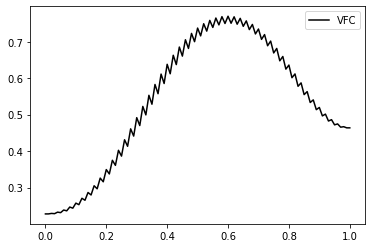

In [8]:
#plt.plot(X, Un_Rsnv, '*-g', label='Rsnv')
#plt.plot(X, Un_Rsnv2, '*-k', label='Rsnv2')
#plt.plot(X, Un_LF, '*-y', label='L-F')
#plt.plot(X, Un_LFM, '*-c', label='L-F mod')
#plt.plot(X, Un_LW, '*-r', label='L-W')
#plt.plot(X, Un_Roe, '*-b', label='Roe')
plt.plot(X, Un_VFC, '-k', label='VFC')
#plt.plot(X, U0, '-g', label='U0')


plt.legend()
###################
#plt.xlim([0.4, 0.8])
#plt.ylim([0.6, 0.82])  

plt.show()

In [76]:
Norm_Roe =  np.linalg.norm(Un_Roe,ord = 2) 
Norm_Rsnv =  np.linalg.norm(Un_Rsnv,ord = 2) 
Norm_Rsnv2 =  np.linalg.norm(Un_Rsnv2,ord = 2) 
Norm_LF =  np.linalg.norm(Un_LF,ord = 2) 
Norm_LFM =  np.linalg.norm(Un_LFM,ord = 2) 
Norm_VFC =  np.linalg.norm(Un_VFC,ord = 2) 
Norm_LW =  np.linalg.norm(Un_LW,ord = 2) 

print(f"La norme pour le schema de Roe: {Norm_Roe}")
print(f"La norme pour le schema Rusanov2: {Norm_Rsnv2}")
print(f"La norme pour le schema Lax-Freiderichs modifie: {Norm_LFM}")
print(f"La norme pour le schema Rusanov: {Norm_Rsnv}")
print(f"La norme pour le schema Lax-Freiderichs: {Norm_LF}")
print(f"La norme pour le schema Lax-Wendroff: {Norm_LW}")
print(f"La norme pour le schema volume fini carac: {Norm_VFC}")


La norme pour le schema de Roe: 5.659013969471633
La norme pour le schema Rusanov2: 5.658890018861186
La norme pour le schema Lax-Freiderichs modifie: 5.631001157246609
La norme pour le schema Rusanov: 5.6535937660916336
La norme pour le schema Lax-Freiderichs: 8524.499645712662
La norme pour le schema Lax-Wendroff: 5.664226779376086
La norme pour le schema volume fini carac: 5.66415062061382


### Cas d'un point sonique:

In [110]:
ul = -1
um = 1
ur = 0.4
T = 1/8
l = 0
L = 1
a = 2
epsilon = 0.008
alpha = 0.7
N = 101
CFL1 = 0.25
CFL2 = 1
X = np.linspace(l,L,N)

U0=np.array([u0(x) for x in X])
Un_Roe = NonLinearBurgerSolver(Roe, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_Rsnv = NonLinearBurgerSolver(Rusanov, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_Rsnv2 = NonLinearBurgerSolver(Rusanov2, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LF = NonLinearBurgerSolver(LF, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LFM = NonLinearBurgerSolver(LFM, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_LW = NonLinearBurgerSolver(LW, u0, epsilon, T, l, L, N, CFL1, CFL2)
Un_VFC = NonLinearBurgerSolver(VFC, u0, epsilon, T, l, L, N, CFL1, CFL2)



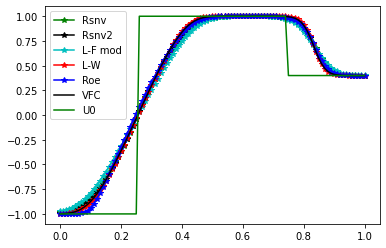

In [111]:
plt.plot(X, Un_Rsnv, '*-g', label='Rsnv')
plt.plot(X, Un_Rsnv2, '*-k', label='Rsnv2')
#plt.plot(X, Un_LF, '*-y', label='L-F')
plt.plot(X, Un_LFM, '*-c', label='L-F mod')
plt.plot(X, Un_LW, '*-r', label='L-W')
plt.plot(X, Un_Roe, '*-b', label='Roe')
plt.plot(X, Un_VFC, '-k', label='VFC')
plt.plot(X, U0, '-g', label='U0')


plt.legend()
###################
#plt.xlim([0.4, 0.8])
#plt.ylim([0.6, 0.82])  

plt.show()